In [1]:
import numpy as np
import mglearn
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

## Random Forest

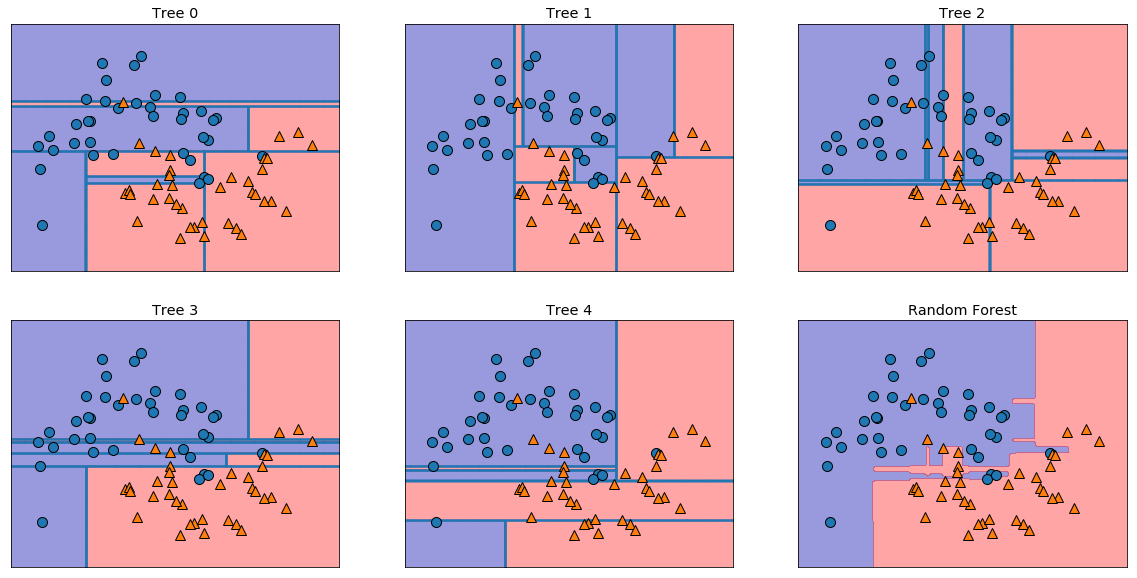

In [2]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train) 
 
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train);

Scikit-learn algorithms:

- `RandomForestClassifier` (or Regressor)
- `ExtraTreesClassifier`: Grows deeper trees, faster

Most important parameters:

* `n_estimators` (higher is better, but diminishing returns)
* `max_features` (default is typically ok)
    * Set smaller to reduce space/time requirements
* parameters of trees, e.g. `max_depth` (less effect)

`n_jobs` sets the number of parallel cores to run  
`random_state` should be fixed for reproducibility

In [3]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [4]:
# Using decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.881


In [5]:
# Using random forest
forest = RandomForestClassifier(n_estimators=10, random_state=0) # Vary n_estimators
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.951


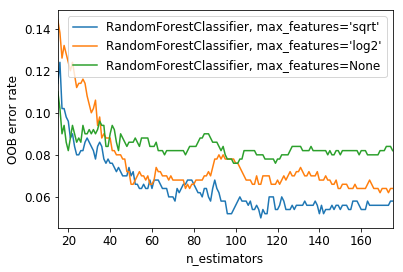

In [6]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

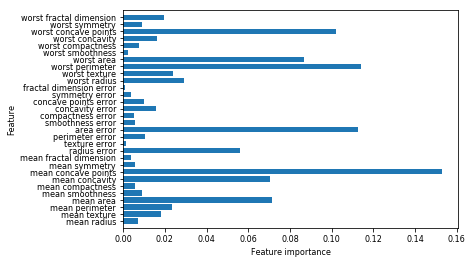

In [7]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plt.rcParams.update({'font.size':8})
plot_feature_importances_cancer(forest)

## Gradient Boosted Regression Trees (Gradient Boosting Machines)
Instead of reducing the variance of overfitted models, reduce the bias of underfitted models

* Use strong pre-pruning to build very shallow trees
    * Default `max_depth`=3
* Iteratively build new trees by increasing weights of points that were badly predicted
    * `learning rate` controls how strongly the weights are altered in each iteration (default 0.1)
    * Gradient descent (covered later) finds optimal set of weights
* Repeat `n_estimators` times (default 100)

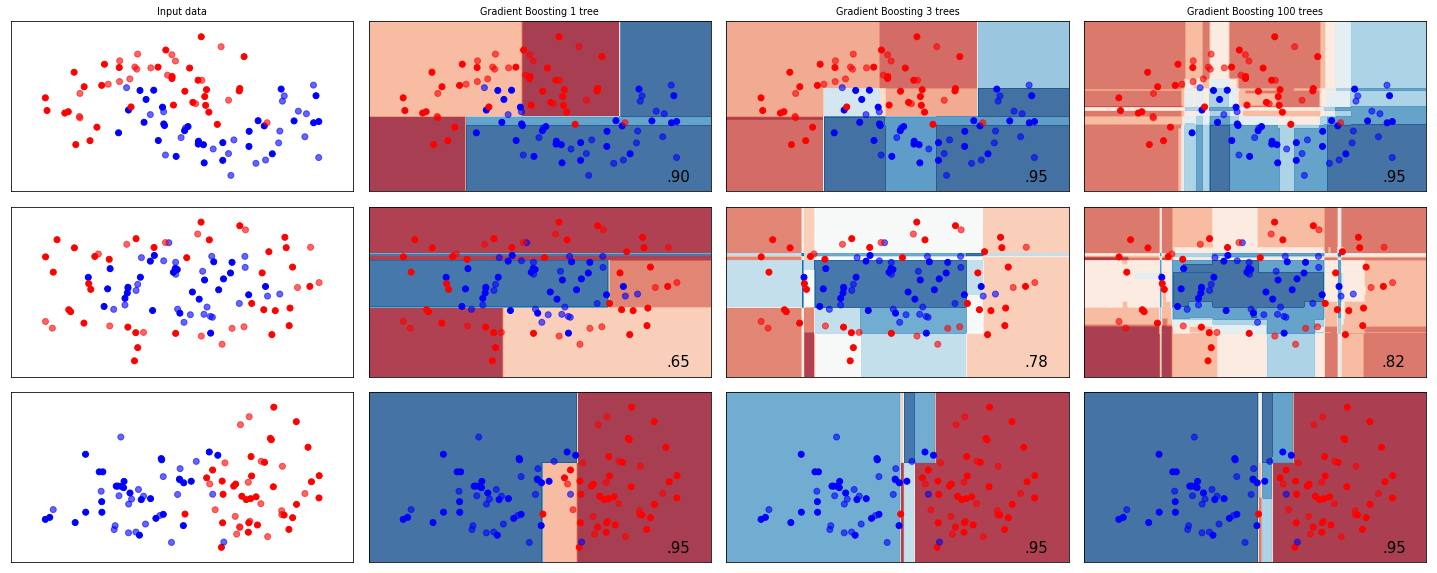

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import plot_classifiers as pc
names = ["Gradient Boosting 1 tree", "Gradient Boosting 3 trees", "Gradient Boosting 100 trees"]

classifiers = [
    GradientBoostingClassifier(n_estimators=1, random_state=0, learning_rate=0.5),
    GradientBoostingClassifier(n_estimators=3, random_state=0, learning_rate=0.5),
    GradientBoostingClassifier(n_estimators=100, random_state=0, learning_rate=0.5)
    ]

pc.plot_classifiers(names, classifiers, figuresize=(20,8))

In [9]:
# We are overfitting. We can decrease max_depth
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [10]:
# or decrease the learning rate (less effect)
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


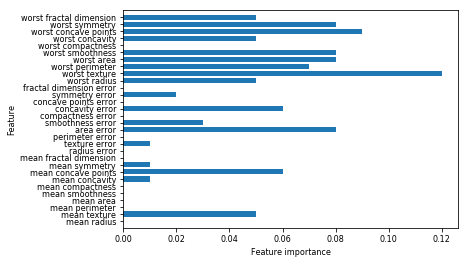

In [11]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

Comparison

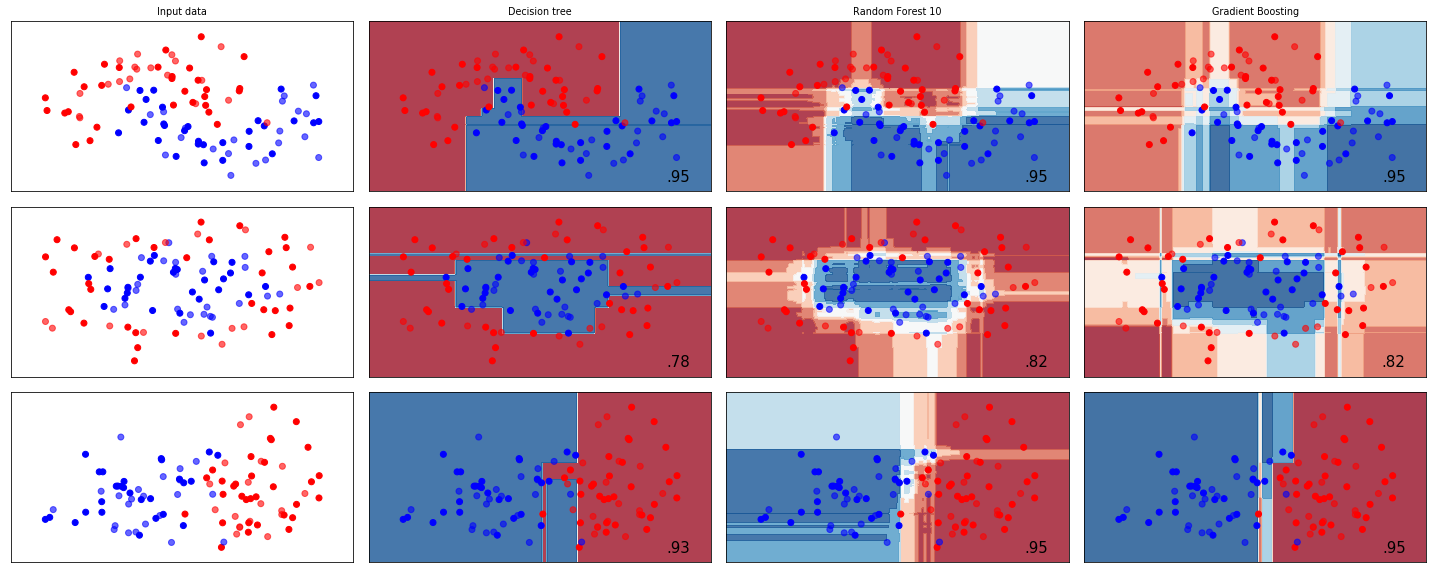

Accuracy on training set: 1.000
Accuracy on test set: 0.881
Accuracy on training set: 1.000
Accuracy on test set: 0.951
Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [12]:
import plot_classifiers as pc
names = ["Decision tree", "Random Forest 10", "Gradient Boosting"]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    GradientBoostingClassifier(random_state=0, learning_rate=0.5)
    ]

pc.plot_classifiers(names, classifiers, figuresize=(20,8))
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))